# Implementing Physics Informed Neural Networks (PINNs) with pulsarfitpy

In addition to polynomial approximations, pulsarfitpy also offers an intuitive PyTorch framework using [Physics Informed Neural Networks (PINNs)](https://arxiv.org/abs/1711.10561) to analyze differential equations in comparison to observed ATNF data. We believe the PINN framework will be beneficial when testing the validity of many theoretical physics expressions in pulsar analysis. Below, we sample a scientifically accepted formula cited by [Belvedere](https://iopscience.iop.org/article/10.1088/0004-637X/799/1/23) and many other studies regarding the surface magnetic field $B$, period $P$, and period derivative $\dot P$, as shown here:

| $\large B \approx 3.2 \cdot 10^{19} (P \dot P)^{1/2}$ |
|:-:|

In this notebook, we experimentally determine an approximation for $3.2 \cdot 10^{19}$ through the variable $N$ using pulsarfitpy & ATNF data, and how to use its constant finder feature in a real theoretical system.

## Developing A Compatible System for the Module

Before we dive into using the PINN feature, it's worth noting how to actually create a suitable differential equation for the PyTorch backend to recognize. In other words, it's critical to make sure each part of the function is:

- Accurate
- Contains parameters from psrqpy
- Compatible with logarithmic functions for extremely low/high data points (heavily recommended)

To adhere to these conditions, we derive an expression involving the logarithmic version of the equation. We first start off with the general identity of $B$ in pulsar analysis, defined as:

| $\large B \approx 3.2 \cdot 10^{19} (P \dot P)^{1/2}$ |
|:-:|

For experimental purposes and verification, we can set the $3.2 \cdot 10^{19}$ scalar to the variable $N$, yielding:

| $\large B = N \cdot (P \dot P)^{1/2}$ | 
|:-:|

Finally, to make the model compatible with the PyTorch framework, creating a logarithmic scale is preferred to accurately train the model and its visualizations, especially with both extremely high and low values in the system. Taking the $\log()$ of both sides yields the final expression for our model:

| $\large \Rightarrow \log(B) = \log(N \cdot (P \dot P)^{1/2})$ |
|:-:|

| $\large \Rightarrow \boxed{\log(B) = \log(N) + \frac{1}{2}\log(P) + \frac{1}{2} \log(\dot P)}$ | 
|:-:|

Since this expression fits our three criteria, we will use this theoretical framework and experimentally determine N using the PulsarPINN class below.

# Understanding the PulsarPINN Class

>[NOTE]
> Some of the class inputs involve specific parameters to be accessed by psrqpy. Refer to the [psrqpy documentation](https://psrqpy.readthedocs.io/_/downloads/en/latest/pdf/) and the [legend of ATNF parameters](https://www.atnf.csiro.au/research/pulsar/psrcat/psrcat_help.html?type=expert#par_list) if needed.

To implement this theoretical model into our library, a proper overview of the PulsarPINN class is detailed here.

The class contains 7 main arguments:

- ```x_param=```[str]: The desired parameter for the x-axis for the generated graph; must be an ATNF parameter that psrqpy can recognize.
- ```y_param=```[str]: The desired parameter for the y-axis for the generated graph; must be an ATNF parameter that psrqpy can recognize.
- ```differential_eq=```[sympy.Eq]: The differential equation the PINN should abide by, using sympy's symbolic notation.
- ```x_sym=```[sympy.Symbol]: The symbol equivalent to the x_param in the differential equation (can also be the log of the parameter version if needed).
- ```y_sym=```[sympy.Symbol]: The symbol equivalent to the y_param in the differential equation (can also be the log of the parameter version if needed).
- ```learn_constants=```[dict]: A dictionary containing the values that are to be experimentally analyzed, along with a coresponding initial guess for the value.
- ```log_scale=```[bool]: Determines if the data points should be taken the $\log()$ of. Set to true by default.
- ```fixed_inputs=```[dict]: The known inputs of the differential equation othat than the chosen ```x_param``` and ```y_param```.

The class also contains 7 main functions:

- ```.train()```: The function used to train the PINN with PyTorch and print the learnt constant. The function contains the ```epochs=``` argument; set to 3000 by default. Depending on how accurate you want your PINN to be, a higher epoch value may be suitable for your own model.
- ```.predict_extended()```: Predicts the extended pattern of the graph based on the neural network. Useful for exploring pulsar dynamics on uncharted scales.
- ```.store_learned_constants()```: Stored the learned constant(s) it into the requested variable.
- ```.recommend_initial_guesses()```: Prints an initial guess for where to start based on a variety of guessing methods using the ```method=``` argument:
    - ```'mean'```: Takes the average value between the x and y datasets from psrqpy.
    - ```'regression'```: Uses sklearn to make a rough linear regression model and prints recommended value based on its slope.
    - ```'ols_loglog'```: Solves ordinary least squares system to compute an approximate linear slope & intercept of the data.
    - ```'zero'```: Sets the recommended value to zero.
- ```.set_learn_constants()```: Sets the to be learned constants based on the ```.recommend_initial_guesses()``` function's recommendation.
- ```.plot_PINN()```: Automatically lots the trained PINN using matplotlib alongside empirical ATNF data. For manual plotting, go to the end of the document for an example.
- ```.plot_PINN_loss()``` Plots the Loss v. Epoch curve detailed while training the model. Includes the physical loss, data loss, and total loss curves displayed on a matplotlib graph.

Some important parameters can be mentioned as the following:

- ```.x_data```: Plotted psrqpy data for the x-axis of the generated graph.
- ```.y_data```: Plotted psrqpy data for the y-axis of the generated graph.
- ```.loss_log```: Contains the total loss profile while training the model. Contains the following indexes:
    - ```["physics"]```: Dictates the physics loss profile of the PINN model during training.
    - ```["data"]```: Contains the data loss while training the PINN.
    - ```["total"]```: The total loss profile of the PINN model while training, including both physics and data losses.

# Using the PulsarPINN Class With the Theoretical Pulsar Framework

Firstly, define variables and the differential equation in your code using sympy and numpy for constants.

In [1]:
import sympy as sp
import numpy as np

logP, logPDOT, logB = sp.symbols('logP logPDOT logB')
logN = sp.Symbol('logN')

differential_equation = sp.Eq(logB, logN + 0.5 * (logP) + 0.5 * (logPDOT))

Next, create a psrqpy query to fetch data for the PDOT values, and take the logarithm base 10 of the PDOT data for the ```fixed_inputs=``` argument.

In [2]:
from psrqpy import QueryATNF

query = QueryATNF(params=['P0', 'P1', 'BSURF'], condition='exist(P0) && exist(P1) && exist(BSURF)')
table = query.table

P = table['P0'].data 
PDOT = table['P1'].data  
BSURF = table['BSURF'].data 

logPDOT_data = np.log10(PDOT)

Define dictionaries containing the constants that are to be learned in the PINN and the fixed data values from the psrqpy wrapper. An initial guess for the value is required to computationally determine if the variable needs to go higher or lower.

In [3]:
learn_constants = {logN: 18}         # Required Initial guess
fixed_data = {logPDOT: logPDOT_data} # Correllate the logPDOT to real ATNF data

Call an instance to the PulsarPINN class and put the required information into the class, as shown. The class will create a graph based on the ```x_param``` and ```y_param``` inputs.

In [4]:
from pulsarfitpy import PulsarPINN

pinn = PulsarPINN(
    x_param='P0',    
    y_param='BSURF',          
    differential_eq=differential_equation,
    x_sym=logP,
    y_sym=logB,
    learn_constants=learn_constants,
    log_scale=True,
    fixed_inputs=fixed_data  # Supply logPDOT externally
)

After creating the class, the user can also have the program suggest initial guesses for the constant K using the ```.recommend_initial_guesses()``` as shown here:

In [5]:
pinn.recommend_initial_guesses(method='mean')
pinn.recommend_initial_guesses(method='regression')
pinn.recommend_initial_guesses(method='ols_loglog')

Recommended initial guesses:
  logN ≈ -2.215211e+01
Recommended initial guesses:
  logN ≈ 1.470686e+00
Recommended initial guesses:
  logN ≈ 1.470686e+00


{logN: np.float64(1.4706862200185216)}

After inputting the needed arguments, the PINN can now start training. Simply call the ```.train()``` method in your code and enter the desired epochs for the model, and record the learned constants using ```.store_learned_constants()```.

In [6]:
pinn.train(epochs=10000)
learned_values = pinn.store_learned_constants()

Training PINN...

Epoch 0: Loss = 2.4544534787e+02 | logN=17.9990
Epoch 1000: Loss = 1.9113245531e+00 | logN=17.9818
Epoch 2000: Loss = 1.3326483793e+00 | logN=18.3703
Epoch 3000: Loss = 8.7044964574e-01 | logN=18.8025
Epoch 4000: Loss = 6.6259421257e-01 | logN=19.1751
Epoch 5000: Loss = 6.0186194201e-01 | logN=19.4061
Epoch 6000: Loss = 5.8855069902e-01 | logN=19.4912
Epoch 7000: Loss = 5.8287361300e-01 | logN=19.5043
Epoch 8000: Loss = 5.7956914980e-01 | logN=19.5049
Epoch 9000: Loss = 5.7739240443e-01 | logN=19.5050

Learned constants: logN = 19.5050978305343498675483715


If desired, the user may also use the option to visualize the neural network's progress through a matplotlib graph and the ```.plot_PINN()``` function.

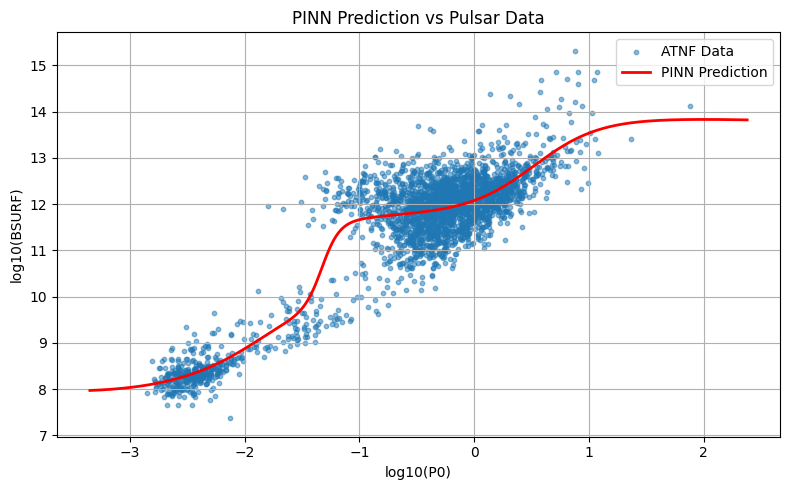

In [7]:
pinn.plot_PINN()

Based on the visualization, we see that the PINN strongly aligns with the ATNF data, rendering our generated $\log(N)$ value true. Additionally, the user also has the option to plot the error curves during its training by calling the ```.plot_PINN_loss()``` function.

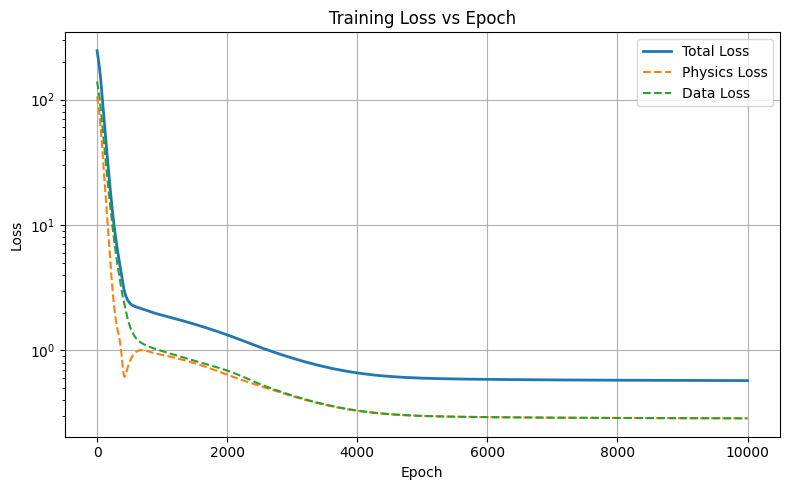

In [8]:
pinn.plot_PINN_loss()

As the learning parameter $\log(N)$ approaches the known scalar value, the PINN starts to get closer and closer to the desired output after many usages of the program. Finally, to print the value of $N$, fetch the value of it from the ```learned_values``` list, and exponentiate it by 10 for the final observed value.

In [9]:
logN_value = learned_values.get('logN')
N = 10 ** logN_value
print(f"Learned that N ≈ {N:.10e}")

Learned that N ≈ 3.1996157840e+19


We can see that this is a great approximation in comparison to the actual value in the formula.

## Manual PINN Plotting with pulsarfitpy

For manual plots, pulsarfitpy offers a simple way to make customizable plots. We exemplify this flexibility by using different x- & y-axis labels and the ability to configure the plots as needed. Create the plot configurations for the PINN data and assign variables to interact with the ```plt.scatter()``` function:

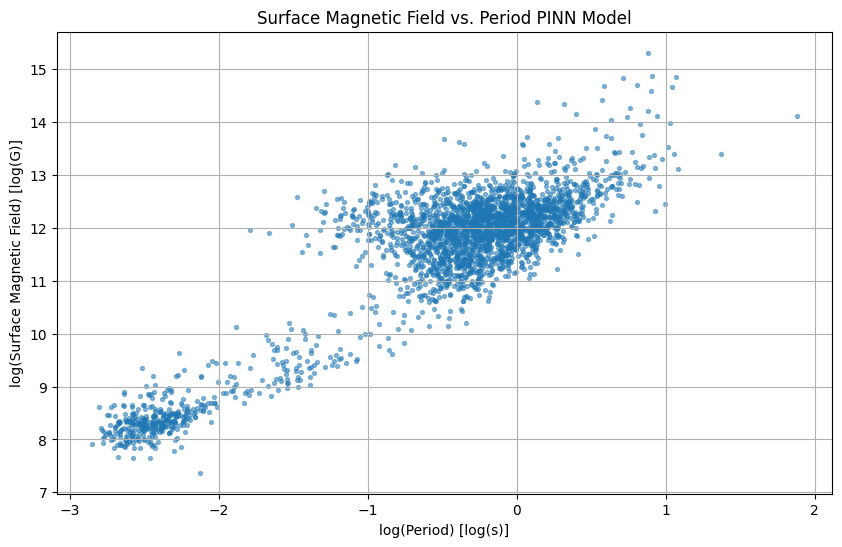

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Surface Magnetic Field vs. Period PINN Model")
plt.xlabel('log(Period) [log(s)]')
plt.ylabel('log(Surface Magnetic Field) [log(G)]')
plt.grid(True)

x_data = pinn.x_raw
y_data = pinn.y_raw

plt.scatter(x_data, y_data, label='ATNF Pulsars', s=8, alpha=0.5)

Finally, plot the PINN function using the ```.predict_extended()``` and display the graph.

[]

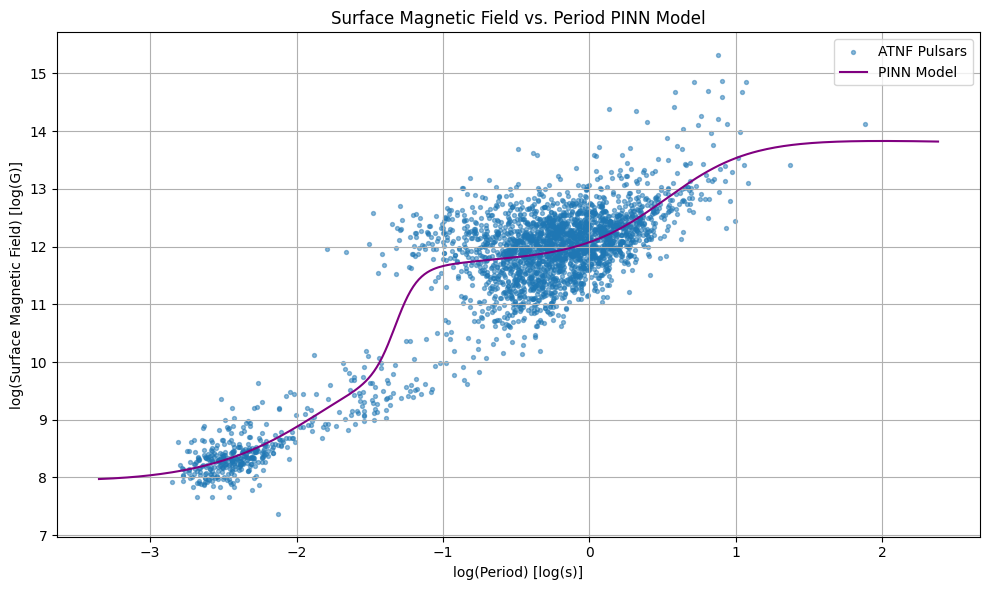

In [11]:
plt.figure(figsize=(10, 6))
plt.title("Surface Magnetic Field vs. Period PINN Model")
plt.xlabel('log(Period) [log(s)]')
plt.ylabel('log(Surface Magnetic Field) [log(G)]')
plt.grid(True)

x_data = pinn.x_raw
y_data = pinn.y_raw

plt.scatter(x_data, y_data, label='ATNF Pulsars', s=8, alpha=0.5)

# Plot the model
x_PINN, y_PINN = pinn.predict_extended()
plt.plot(x_PINN, y_PINN, color='purple', label='PINN Model')
plt.legend()
plt.tight_layout()
plt.plot()

To plot the error curves during the training of the PINN, create a new matplotlib figure and use the ```plt.plot``` function and the ```.loss_log``` indexes as such:

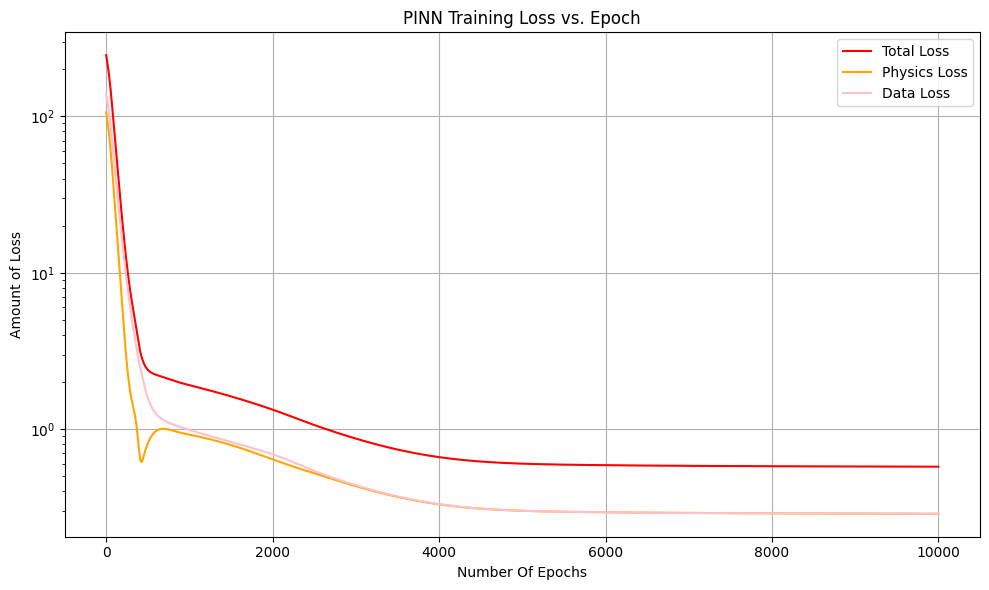

In [12]:
plt.figure(figsize=(10, 6))
plt.title('PINN Training Loss vs. Epoch')
plt.xlabel('Number Of Epochs')
plt.ylabel('Amount of Loss')
plt.yscale('log') # For high error values

# Plot the function 
plt.plot(pinn.loss_log["total"], label='Total Loss', color='red')
plt.plot(pinn.loss_log["physics"], label='Physics Loss', color='orange')
plt.plot(pinn.loss_log["data"], label='Data Loss', color='pink')

plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

This sums up the basics of the intuitive PyTorch neural network feature in our library.